# Bed Space Optimisation

by James Gopsill

![alt text](optimised.png "Optimised Bed")

<hr>

3D Managed Print Services is a rapidly developing industry where they offer 3D printing services to their customers. These services typically range from 1-20 printers and often involve users submit their jobs one after another throughout the day. However, with the submission process moving towards an online queue format, there lies oppotunities in optimising the utilisation of the 3D printers' bed space in order to help maximise throughput of parts.

This python notebook demonstrates how indvidual part g-code can be extracted from a file containing multiple parts. By splitting the g-code with respect to the individual parts, this can enables the translation of parts from multiple files in order to maximise the utilisation of the bed space. To achieve this, the notebook uses DBSCAN for the identification of parts and First-Fit Decreasing Height (FFDH) in order to define an optimally utilised bed space. This work was presented at the International Sustainable Design & Manufacturing conference in 2015 ([Gopsill et al., 2015][1]).

Before we start, we need to load the python packages that we will be using:

* re - Regex to identify the lines of g-code that are of interest
* matplotlib - For plotting the results
* numpy - to handle and manipulate matrices
* pprint - pretty printing of console output
* Axer3D - for 3d visualisation
* DBSCAN - to identify clusters of points that make up the parts within the file
* itemgetter - for ordering a list of dictionary objects

[1]: [http://nbviewer.jupyter.org/github/JamesGopsill/publications/blob/gh-pages/papers/conference/sdm2015/sdm2015.pdf]



In [2]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import re
import matplotlib.pyplot as plt
import numpy as np
import pprint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from operator import itemgetter

pp = pprint.PrettyPrinter(indent=2)

## Loading the G-Code File

The first thing we have to do is load the g-code file into python

In [3]:
with open('bed_one.gcode', 'r') as f:
    contents_of_file = f.read() # Make a list of lines of gcode
    
pp.pprint(contents_of_file[0:500])

('M136 (enable build)\n'
 'M73 P0\n'
 'G162 X Y F2000(home XY axes maximum)\n'
 'G161 Z F900(home Z axis minimum)\n'
 'G92 X0 Y0 Z-5 A0 B0 (set Z to -5)\n'
 "G1 Z0.0 F900(move Z to '0')\n"
 'G161 Z F100(home Z axis minimum)\n'
 'M132 X Y Z A B (Recall stored home offsets for XYZAB axis)\n'
 'G92 X152 Y75 Z0 A0 B0\n'
 'G1 X-141 Y-74 Z40 F3300.0 (move to waiting position)\n'
 'G130 X20 Y20 A20 B20 (Lower stepper Vrefs while heating)\n'
 'M135 T0\n'
 'M104 S230 T0\n'
 'M133 T0\n'
 'G130 X127 Y127 A127 B127 (Set Stepper motor Vref to defaults)\n'
 '; Makerbot Industries\n'
 '; Mi')


## Extract the G-Code Positions

Once we have loaded the g-code file in, we can extract the relevant g-code commands that are used to deposit material for the parts. We do this by using a regex command that extracts the x, y and z co-ordinates from the G1 commands.

In [4]:
# Extracting the co-ordinates from the g-code
tokens = re.findall('G1 X(.*?) Y(.*?) Z(.*?) F', contents_of_file)
print('Regex Result')
print(len(tokens))
print(tokens[0:10])

Regex Result
189436
[('-141', '-74', '40'), ('105.400', '-74.000', '0.270'), ('-141', '-74', '0.270'), ('-141.0', '-74.0', '0.0'), ('-141.000', '-74.000', '0.000'), ('-141.000', '-74.000', '0.200'), ('-83.513', '-39.441', '0.200'), ('-83.513', '-39.441', '0.200'), ('-82.475', '-40.374', '0.200'), ('-81.240', '-41.174', '0.200')]


This forms a list of tuples with three strings in each. To be able to use this in the rest of the analysis, we need to convert the string into floats and place into a numpy array.

In [5]:
# Placing co-odinates into and array and changing the values from strings to floats
print('- Numpy Array -')
g_code_co_ordinates = np.asarray(tokens, dtype=np.float32)
print(g_code_co_ordinates.shape)
print(g_code_co_ordinates)

- Numpy Array -
(189436, 3)
[[-141.          -74.           40.        ]
 [ 105.40000153  -74.            0.27000001]
 [-141.          -74.            0.27000001]
 ..., 
 [  36.90200043   42.17399979   44.        ]
 [  33.57400131   45.5019989    44.        ]
 [  33.57400131   45.5019989    44.        ]]


Once done, we can visualise the points we have extracted using the 3D plotting library that is part of the matplotlib package. Figure 1 reveals that thee are a number of parts within the g-code file as well as a few points that come from the start and end positions of the printer head.

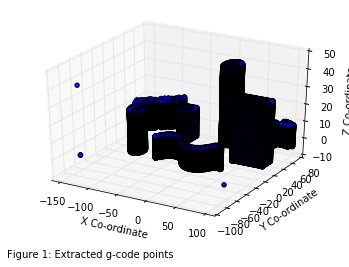

In [6]:
set_matplotlib_formats('png') # As there are so many points we should plot as a png
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_code_co_ordinates[:,0], g_code_co_ordinates[:,1], g_code_co_ordinates[:,2], '.')
plt.xlim(-150, 150)
plt.axis('equal')
ax.set_xlabel('X Co-ordinate')
ax.set_ylabel('Y Co-ordinate')
ax.set_zlabel('Z Co-ordinate')
# Figure label
plt.annotate('Figure 1: Extracted g-code points', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

As there are 189,436 points within this single g-code file, the clustering of all the points is a little too computationally expensive for this demo. Therefore, we will take a 'slice' from this code and identify parts through this subset of data. Although, the algorithms are able to cope wth the entire point-cloud.

The following code takes all the points at a specific height (z) in the g-code and the results are plotted on a 2d plane (Figure 2).

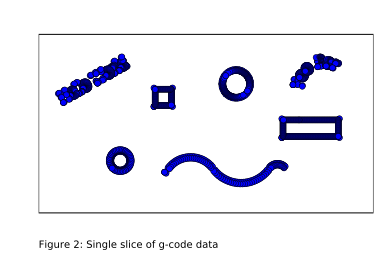

In [7]:
# Creating a top-down view plot using a slice of the 3d data
plane = g_code_co_ordinates[np.where(g_code_co_ordinates[:,2] == 0.6)]

# set the printer bed space
bedsize_x = [-150, 150, 150, -150, -150]
bedsize_y = [-80, -80, 80, 80, -80]
     
set_matplotlib_formats('pdf', 'svg')
plt.plot(bedsize_x, bedsize_y, '-k')
plt.plot(plane[:,0], plane[:,1], 'o')
plt.xlim(-150, 150)
plt.axis('equal')
plt.axis('off')
plt.annotate('Figure 2: Single slice of g-code data', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Using DBSCAN to identify parts

At this moment, the computer has now idea that the points represent different parts. Therefore, we need a method of identifying the parts so that we can translate the all the points as one. To achieve this, we will use DBSCAN, which is clustering technique that identify clusters based on the density of points within a space. We can also set threshold for the minimum number of points required to form a cluster and hence, noise (such as the points indicating the start and end positions) will be removed during the analysis.

Once we have identified the clusters, we can create a bounding box around the associated points and this can be used in the FFDH algorithm in order to optimise the bed space. Figure 3 shows the clusters and bounding boxes that have been generated from the post processing of the DBSCAN results.

Number of clusters: 7


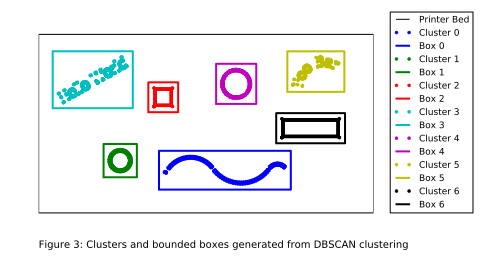

In [8]:
# Run db scan on the plane of interest 
db = DBSCAN(eps=10, min_samples=10).fit(plane[:,0:2])

# Retrieve the labels of the clusters
labels = db.labels_

# identify the number of clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: %d' % n_clusters)

# set a range of colors to be used in the plotting of the results
colors = 'bgrcmyk'

# plot the pritner bed space
plt.plot(bedsize_x, bedsize_y, '-k', label='Printer Bed')

# Create a list for the cluster data
clustered_data = []
# for each cluster, identify the points within the cluster and set a bounding box for the points
for i in range(0, n_clusters):
    x = []
    y = []
    # check the labels for each point to see if they match the cluster number
    for n, label in enumerate(labels):
        if label == i:
            x.append(plane[n,0])
            y.append(plane[n,1])
    
    # plot the points within the cluster
    plt.plot(x, y, '.', color=colors[i], label='Cluster '+str(i))
    
    # create a bounding box for the points
    min_x = min(x) - 5
    max_x = max(x) + 5
    min_y = min(y) - 5
    max_y = max(y) + 5
    area_x = [min_x, max_x, max_x, min_x, min_x]
    area_y = [min_y, min_y, max_y, max_y, min_y]
    
    # add this information to the clustered data list in the form of a dictionary
    clustered_data.append({
            'width': max_x - min_x,
            'height': max_y - min_y,
            'x': x,
            'y': y,
            'area_x' : area_x,
            'area_y': area_y,
            'min_x': min_x,
            'min_y': min_y,
            'color': colors[i],
            'name': 'Cluster: '+str(i)
        })
    
    # plot the bounding box for the cluster
    plt.plot(area_x, area_y, '-', linewidth=2, color=colors[i], label='Box '+str(i))
  
# add a legend
set_matplotlib_formats('pdf', 'svg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=9)
plt.annotate('Figure 3: Clusters and bounded boxes generated from DBSCAN clustering', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.xlim(-150, 150)
plt.axis('equal')
plt.axis('off')
plt.show()

## First-Fit Decreasing Height (FFDH)

In order to optimise the utilisation of the bed space, we will apply the First-Fit Decreasing Height (FFDH) algorithm. Although there are many methods that could be applied in order to optimise this space (please see here for some more ideas). In FFDH, the parts are listed in order of their height with the first forming the first line of parts to be printed. You then continue down the list and if the next part fits within the remaining width of the bed space then the part will be place alongside the first. If no parts can fit along the first line, a second line of parts to be printed is formed with the highest remaining part featuring first. This loop continues until all the parts have been exhausted or the entire printer bed space has been allocated. Once the positions of the parts has been solved, the associated g-code for each part is translated. 

The results of this is presented in Figure 4 where it can be seen that the the parts have been neatly packed to the lower left corner. The remaining space could be filled by additional parts orginating from other users' g-codes files that have been submitted to the 3D Managed Print Service.

Adding part to row
Adding part to row
Adding part to row
Part does not fit
Creating new row
Adding part to row
Adding part to row
[0, 1, 2, 3, 4, 5, 6]


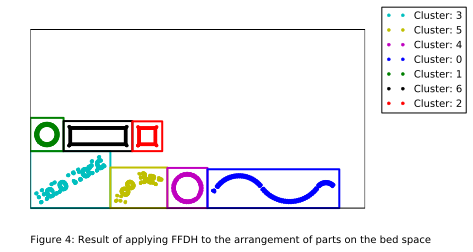

In [9]:
bed_height = 170.0
bed_width = 285.0

bed_area = bed_height * bed_width

clustered_data = sorted(clustered_data, key=itemgetter('height'), reverse=True)

h1 = 0.0
w1 = 0.0

part = clustered_data[0]
h2 = h1 + part['height']
w2 = w1 + part['width']

# Plot bed boundary
plt.plot([w1, w2, w2, w1, w1], [h1, h1, h2, h2, h1], '-', color=part['color'], linewidth=2)
# Plot part points
x_translation = part['min_x'] - w1
y_translation = part['min_y'] - h1
x = part['x'] - x_translation
y = part['y'] - y_translation
plt.plot(x, y, '.', color=part['color'], label=part['name'])

parts_on_bed = [0]
w1 = w2

for i in range(1, len(clustered_data)):
    part = clustered_data[i]
    w2 = w1 + part['width']
    
    if w2 < bed_width:
        # we can fit another part in
        print('Adding part to row')
        plt.plot([w1, w2, w2, w1, w1], [h1, h1, h1+part['height'], h1+part['height'], h1], '-', color=part['color'], linewidth=2)
        # Plot part points
        x_translation = part['min_x'] - w1
        y_translation = part['min_y'] - h1
        x = part['x'] - x_translation
        y = part['y'] - y_translation
        plt.plot(x, y, '.', color=part['color'], label=part['name'])
        
        parts_on_bed.append(i)
        w1 = w2
        continue
    else:
        print('Part does not fit' )  
        pass
    
    if w2 > bed_width and h2 + part['height'] < bed_height:
        # max width has been met and we need to go to a different level if possible
        print('Creating new row')
        h1 = h2
        h2 = h1 + part['height']
        w1 = 0.0
        w2 = w1 + part['width']
        plt.plot([w1, w2, w2, w1, w1], [h1, h1, h1+part['height'], h1+part['height'], h1], '-', color=part['color'], linewidth=2)
        # Plot part points
        x_translation = part['min_x'] - w1
        y_translation = part['min_y'] - h1
        x = part['x'] - x_translation
        y = part['y'] - y_translation
        plt.plot(x, y, '.', color=part['color'], label=part['name'])
        
        parts_on_bed.append(i)
        w1 = w2
        continue

print(parts_on_bed)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
# Figure label
plt.annotate('Figure 4: Result of applying FFDH to the arrangement of parts on the bed space', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.plot([0,300,300,0,0],[0,0,160,160,0],'-k')
plt.xlim(-1, 301)
plt.axis('equal')
plt.axis('off')
plt.show()

The final aspect is to then re-create the g-code file with the new part positions and to also determine the paths that need to be made between the parts given there new arrangement. This has been discussed in the paper and involves solving the travelling salesman problem in order to minimise taken to travel between parts.

## Future Work & References

I hope this example has demonstrated that there is significant potential in optmising the bed space of 3D managed printer services and is something that you will begin to see more often as 3DMPSs' become a more automated process. Work is continuing at the Design Futures Lab (DFL) at the University of Bristol in order to make step change improvements in the efficiency of 3DMPS. In addition, to bed space optimisation, the team are looking at scheduling, health monitoring and reliability of 3DMPS as well as developing tools to support users in designing for 3D printed parts.


In [10]:
# Setting the css styling of the notebook
from IPython.core.display import HTML

def load_css():
    style = open("../extras/custom.css", "r").read()
    return HTML("<style>"+style+"</style>")

load_css()